<a href="https://colab.research.google.com/github/jhchang/Tensorflow_projects/blob/main/TimeSeriesPredictWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# Need a compute power of 7.0+ to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d58e25ef-041d-1985-e799-72f6225f8c9f)


In [111]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [112]:
import numpy as np
from tensorflow.keras import layers

In [113]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [114]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
if os.path.exists('TimeSeriesWeather/'):
    print('Directory already exists')
else:
    !mkdir -p TimeSeriesWeather
    !unzip /content/drive/MyDrive/TimeSeriesWeather.zip -d TimeSeriesWeather

Directory already exists


In [117]:
data_dir = "TimeSeriesWeather/"

In [118]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['TimeSeriesWeather/DailyDelhiClimateTest.csv',
 'TimeSeriesWeather/DailyDelhiClimateTrain.csv']

In [119]:
!pwd

/content


In [120]:
!ls

drive		     model_experiments	sample_data
helper_functions.py  __pycache__	TimeSeriesWeather


In [121]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("TimeSeriesWeather/DailyDelhiClimateTrain.csv", 
                 parse_dates=["date"], 
                 index_col=["date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [123]:
# How many samples do we have?
len(df)

1462

In [124]:
# Only want closing price for each day 
mean_temps = pd.DataFrame(df["meantemp"])
mean_temps.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


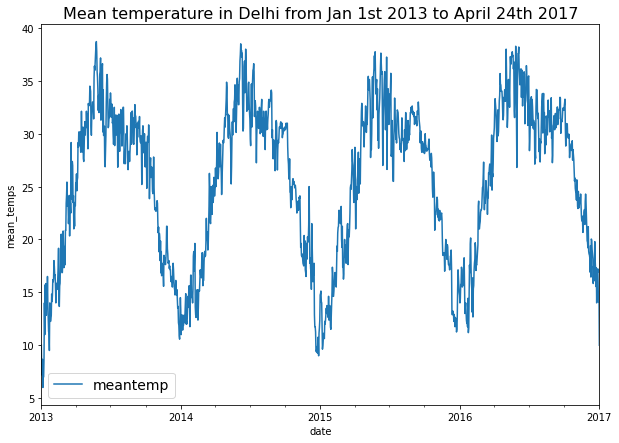

In [125]:
import matplotlib.pyplot as plt
mean_temps.plot(figsize=(10, 7))
plt.ylabel("mean_temps")
plt.title("Mean temperature in Delhi from Jan 1st 2013 to April 24th 2017", fontsize=16)
plt.legend(fontsize=14);

In [126]:
# Get bitcoin date array
timesteps = mean_temps.index.to_numpy()
meantemps_np = mean_temps["meantemp"].to_numpy()

timesteps[:10], meantemps_np[:10]

(array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000',
        '2013-01-03T00:00:00.000000000', '2013-01-04T00:00:00.000000000',
        '2013-01-05T00:00:00.000000000', '2013-01-06T00:00:00.000000000',
        '2013-01-07T00:00:00.000000000', '2013-01-08T00:00:00.000000000',
        '2013-01-09T00:00:00.000000000', '2013-01-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([10.        ,  7.4       ,  7.16666667,  8.66666667,  6.        ,
         7.        ,  7.        ,  8.85714286, 14.        , 11.        ]))

In [127]:
# Create train and test splits the right way for time series data
split_size = int(0.80 * len(meantemps_np)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], meantemps_np[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], meantemps_np[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1169, 293, 1169, 293)

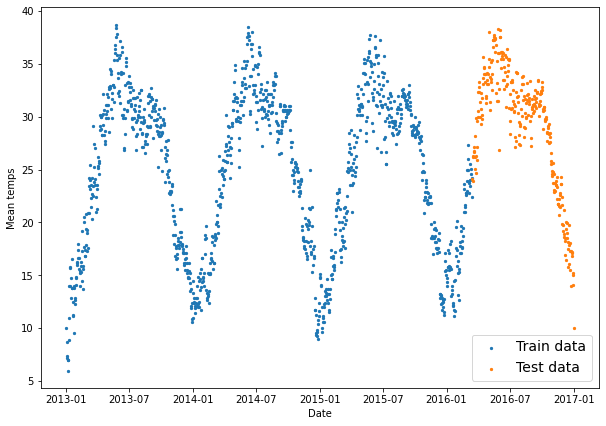

In [128]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Mean temps")
plt.legend(fontsize=14)
plt.show();

In [129]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Mean temps")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

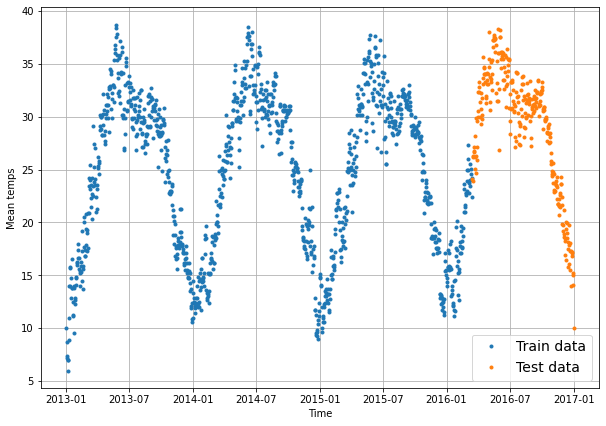

In [130]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [131]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([24.06666667, 23.9375    , 26.3125    , 26.1875    , 26.78571429,
        27.13333333, 26.625     , 25.0625    , 26.2       , 28.13333333]),
 array([17.28571429, 15.55      , 17.31818182, 14.        , 17.14285714,
        16.85      , 17.2173913 , 15.23809524, 14.0952381 , 15.05263158]))

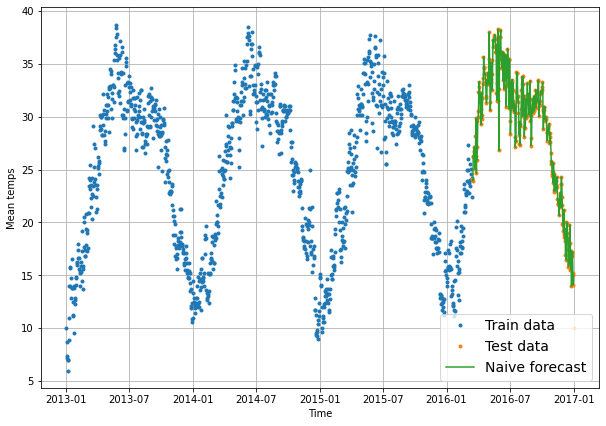

In [132]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

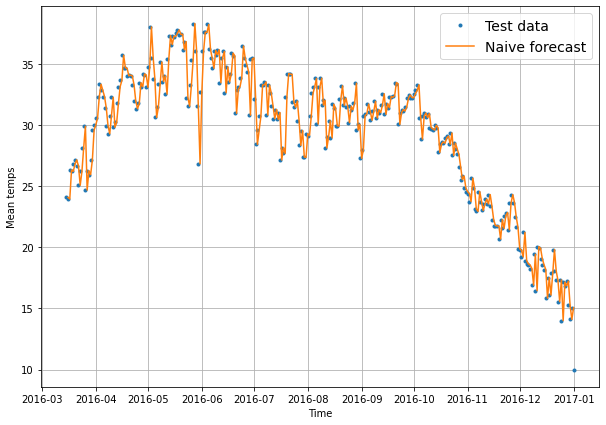

In [133]:
plt.figure(figsize=(10, 7))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [134]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


In [135]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [136]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1.2577628,
 'mse': 2.8376758,
 'rmse': 1.6845403,
 'mape': 4.638832,
 'mase': 0.99692595}

In [137]:
# Find average price of temp in test dataset
tf.reduce_mean(y_test).numpy()

29.23515980008927

In [138]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

dataset = tf.keras.utils.timeseries_dataset_from_array(
    meantemps_np[:-HORIZON], meantemps_np[WINDOW_SIZE+HORIZON-1:], sequence_length=WINDOW_SIZE)
    # prices[:-WINDOW_SIZE+HORIZON], prices[WINDOW_SIZE+HORIZON-1:], sequence_length=7) WRONG DO NOT USE!!!!!!!!!!!
# list(dataset.as_numpy_iterator())[0]

#print first 4 windows for data
print("print first 4 windows for data")
print(list(dataset.as_numpy_iterator())[0][0][:4])

#print first 4 targets
print("print first 4 targets")
print(list(dataset.as_numpy_iterator())[0][1][:4])

print("print first 10 elements in dataset")
print(meantemps_np[:10])

print("\n=======================\n")

#print last 4 windows for data
print("print last 4 windows for target")
print(list(dataset.as_numpy_iterator())[-1][0][-4:])  # first dimension in this dataset is the batch # so the last elements are in the last batch, which is accessed by the -1 index

#print last 4 targets
print("print last 4 targets")
print(list(dataset.as_numpy_iterator())[-1][1][-4:])

print("print last 10 elements in dataset")
print(meantemps_np[-10:])

print(dataset)
# print(list(dataset.as_numpy_iterator()))


print first 4 windows for data
[[10.          7.4         7.16666667  8.66666667  6.          7.
   7.        ]
 [ 7.4         7.16666667  8.66666667  6.          7.          7.
   8.85714286]
 [ 7.16666667  8.66666667  6.          7.          7.          8.85714286
  14.        ]
 [ 8.66666667  6.          7.          7.          8.85714286 14.
  11.        ]]
print first 4 targets
[ 8.85714286 14.         11.         15.71428571]
print first 10 elements in dataset
[10.          7.4         7.16666667  8.66666667  6.          7.
  7.          8.85714286 14.         11.        ]


print last 4 windows for target
[[17.28571429 15.55       17.31818182 14.         17.14285714 16.85
  17.2173913 ]
 [15.55       17.31818182 14.         17.14285714 16.85       17.2173913
  15.23809524]
 [17.31818182 14.         17.14285714 16.85       17.2173913  15.23809524
  14.0952381 ]
 [14.         17.14285714 16.85       17.2173913  15.23809524 14.0952381
  15.05263158]]
print last 4 targets
[15.238095

In [139]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [140]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [141]:
full_windows, full_labels = make_windows(meantemps_np, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1455, 1455)

In [142]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [10.          7.4         7.16666667  8.66666667  6.          7.
  7.        ] -> Label: [8.85714286]
Window: [7.4        7.16666667 8.66666667 6.         7.         7.
 8.85714286] -> Label: [14.]
Window: [ 7.16666667  8.66666667  6.          7.          7.          8.85714286
 14.        ] -> Label: [11.]


In [143]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [15.55       17.31818182 14.         17.14285714 16.85       17.2173913
 15.23809524] -> Label: [14.0952381]
Window: [17.31818182 14.         17.14285714 16.85       17.2173913  15.23809524
 14.0952381 ] -> Label: [15.05263158]
Window: [14.         17.14285714 16.85       17.2173913  15.23809524 14.0952381
 15.05263158] -> Label: [10.]


In [144]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [145]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.20)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1164, 291, 1164, 291)

In [146]:
train_windows[:5], train_labels[:5]

(array([[10.        ,  7.4       ,  7.16666667,  8.66666667,  6.        ,
          7.        ,  7.        ],
        [ 7.4       ,  7.16666667,  8.66666667,  6.        ,  7.        ,
          7.        ,  8.85714286],
        [ 7.16666667,  8.66666667,  6.        ,  7.        ,  7.        ,
          8.85714286, 14.        ],
        [ 8.66666667,  6.        ,  7.        ,  7.        ,  8.85714286,
         14.        , 11.        ],
        [ 6.        ,  7.        ,  7.        ,  8.85714286, 14.        ,
         11.        , 15.71428571]]), array([[ 8.85714286],
        [14.        ],
        [11.        ],
        [15.71428571],
        [14.        ]]))

In [147]:
print(np.squeeze(train_labels[:-HORIZON-1]))

[ 8.85714286 14.         11.         ... 24.5625     24.25
 22.375     ]


In [148]:
print(y_train[WINDOW_SIZE:])

[ 8.85714286 14.         11.         ... 24.5625     24.25
 22.375     ]


In [149]:
len(np.squeeze(train_labels[:-HORIZON-1]))

1162

In [150]:
len(y_train[WINDOW_SIZE:])

1162

In [151]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [152]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [153]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
10/10 [==============================] - 1s 81ms/step - loss: 9.1974 - mae: 9.1974 - val_loss: 1.5992 - val_mae: 1.5992
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 2.8749 - mae: 2.8749 - val_loss: 2.8037 - val_mae: 2.8037
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 1.9133 - mae: 1.9133 - val_loss: 2.0747 - val_mae: 2.0747
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 1.7657 - mae: 1.7657 - val_loss: 1.7458 - val_mae: 1.7458
Epoch 5/100
10/10 [==============================] - 1s 66ms/step - loss: 1.6233 - mae: 1.6233 - val_loss: 1.5501 - val_mae: 1.5501
Epoch 6/100
10/10 [==============================] - 1s 65ms/step - loss: 1.5960 - mae: 1.5960 - val_loss: 1.5230 - val_mae: 1.5230
Epoch 7/100
10/10 [==============================] - 1s 63ms/step - loss: 1.5594 - mae: 1.5594 - val_loss: 1.4735 - val_mae: 1.4735
Epoch 8/100
10/10 [==============================] - 1s 65ms/step - loss: 1.537

In [154]:
model_1.evaluate(test_windows, test_labels)

10/10 [==============================] - 0s 4ms/step - loss: 1.2390 - mae: 1.2390


[1.2389637231826782, 1.2389637231826782]

In [155]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 1.2390 - mae: 1.2390


[1.2389637231826782, 1.2389637231826782]

In [156]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [157]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

10/10 [==============================] - 0s 3ms/step


(291, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([24.307346, 25.94479 , 26.216974, 26.6634  , 26.958132, 26.72631 ,
        25.420496, 26.32216 , 27.885649, 29.41956 ], dtype=float32)>)

In [158]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1.2389638,
 'mse': 2.7991846,
 'rmse': 1.6730764,
 'mape': 4.6026635,
 'mase': 0.98502296}

In [159]:
naive_results

{'mae': 1.2577628,
 'mse': 2.8376758,
 'rmse': 1.6845403,
 'mape': 4.638832,
 'mase': 0.99692595}

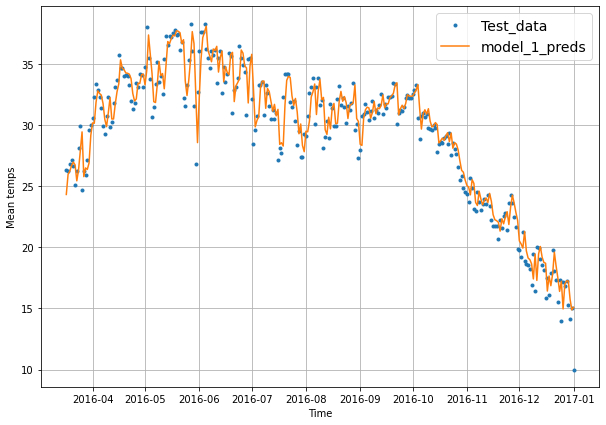

In [160]:
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

In [161]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [162]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(meantemps_np, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1432, 1432)

In [163]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1145, 287, 1145, 287)

In [164]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [165]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

9/9 [==============================] - 0s 2ms/step - loss: 1.2943


1.2942607402801514

In [166]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

9/9 [==============================] - 0s 2ms/step - loss: 1.2943


1.2942607402801514

In [167]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

9/9 [==============================] - 0s 2ms/step


In [168]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1.2942606,
 'mse': 2.9110098,
 'rmse': 1.706168,
 'mape': 4.736191,
 'mase': 1.0192056}

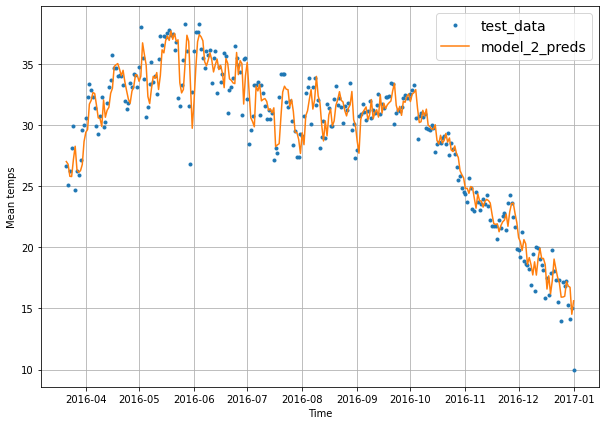

In [169]:
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

In [170]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(meantemps_np, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1426, 1426)

In [171]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1140, 286, 1140, 286)

In [172]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [173]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

9/9 [==============================] - 0s 2ms/step - loss: 1.7218


1.7218388319015503

In [174]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

9/9 [==============================] - 0s 2ms/step - loss: 1.6936


1.6936486959457397

In [175]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

9/9 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[24.325176, 23.924072, 24.52441 , 24.362354, 24.802826, 25.54739 ,
        25.089798],
       [24.546206, 23.726564, 24.623482, 24.843662, 25.090652, 25.197842,
        24.529308],
       [26.001194, 25.484665, 25.008602, 25.381687, 25.506596, 25.79566 ,
        24.760843],
       [26.795609, 25.618637, 25.514696, 26.04537 , 26.05303 , 26.13782 ,
        26.087803],
       [26.493801, 26.171764, 25.70045 , 26.62767 , 26.01839 , 26.10349 ,
        25.690937]], dtype=float32)>

In [176]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [177]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1.6936487,
 'mse': 4.796108,
 'rmse': 1.992962,
 'mape': 5.941473,
 'mase': 1.3502175}

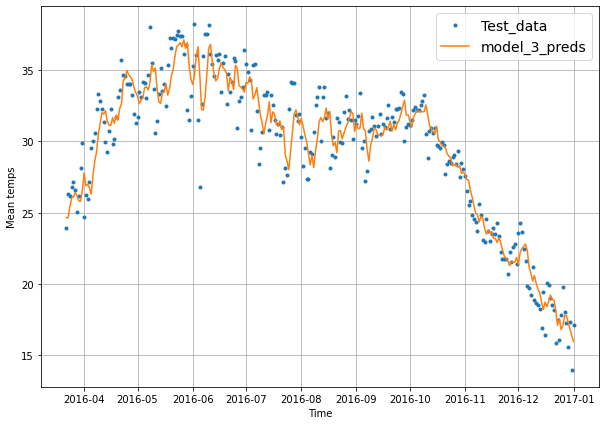

In [178]:
offset = 0
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

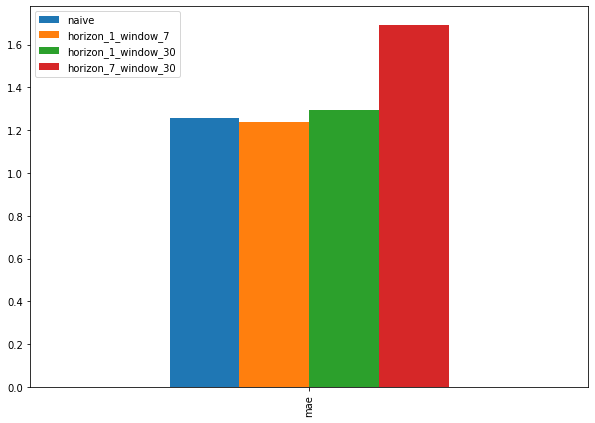

In [179]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

In [180]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [181]:
# Create windowed dataset
full_windows, full_labels = make_windows(meantemps_np, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1455, 1455)

In [182]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1164, 291, 1164, 291)

In [183]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [184]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[10.       ]
 [ 7.4      ]
 [ 7.1666665]
 [ 8.666667 ]
 [ 6.       ]
 [ 7.       ]
 [ 7.       ]]


In [185]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [186]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_18 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [187]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 1.2384


1.2384446859359741

In [188]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

10/10 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([24.182653, 25.674831, 26.142742, 26.489292, 26.913519, 26.694622,
       25.615334, 26.151785, 27.647804, 29.208807], dtype=float32)>

In [189]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 1.2384447,
 'mse': 2.7660706,
 'rmse': 1.6631508,
 'mape': 4.5807223,
 'mase': 0.9846102}

In [190]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [191]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 1.2042


1.204153060913086

In [192]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

10/10 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([24.059658, 25.60666 , 25.97793 , 26.222246, 26.751957, 26.34838 ,
       25.292868, 26.03132 , 27.667604, 29.148174], dtype=float32)>

In [193]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 1.2041531,
 'mse': 2.5879805,
 'rmse': 1.6087202,
 'mape': 4.438367,
 'mase': 0.95734704}

In [194]:
'''
multivariate time series
target: meantemp
data: meantemp, humidity, wind_speed, meanpressure

gonna have to use pandas shift method for all variables so the size of the input
would be n*7. n = # of variables.
4*7=28

dataframe columns will look like this:
meantemp+1, meantemp+2, ..., meantemp + 7, humidity+1, ..., humidity+7, ...
'''

'\nmultivariate time series\ntarget: meantemp\ndata: meantemp, humidity, wind_speed, meanpressure\n\ngonna have to use pandas shift method for all variables so the size of the input\nwould be n*7. n = # of variables.\n4*7=28\n\ndataframe columns will look like this:\nmeantemp+1, meantemp+2, ..., meantemp + 7, humidity+1, ..., humidity+7, ...\n'

In [195]:
# Make a copy of the Bitcoin historical data with block reward feature
multivariate_windowed = df.copy()
n_list = ["meantemp", "humidity", "wind_speed", "meanpressure"]
# Add windowed columns
for name in n_list:
    for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
        multivariate_windowed[f"{name}+{i+1}"] = multivariate_windowed[f"{name}"].shift(periods=i+1)
multivariate_windowed.head(10)

,meantemp,humidity,wind_speed,meanpressure,meantemp+1,meantemp+2,meantemp+3,meantemp+4,meantemp+5,meantemp+6,...,wind_speed+5,wind_speed+6,wind_speed+7,meanpressure+1,meanpressure+2,meanpressure+3,meanpressure+4,meanpressure+5,meanpressure+6,meanpressure+7
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,10.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,7.166667,87.000000,4.633333,1018.666667,7.400000,10.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1017.800000,1015.666667,NaN,NaN,NaN,NaN,NaN
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,1018.666667,1017.800000,1015.666667,NaN,NaN,NaN,NaN
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.400000,10.000000,NaN,NaN,...,NaN,NaN,NaN,1017.166667,1018.666667,1017.800000,1015.666667,NaN,NaN,NaN
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,8.666667,7.166667,7.400000,10.000000,NaN,...,0.000000,NaN,NaN,1016.500000,1017.166667,1018.666667,1017.800000,1015.666667,NaN,NaN
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,...,2.980000,0.000000,NaN,1018.000000,1016.500000,1017.166667,1018.666667,1017.800000,1015.666667,NaN
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,...,4.633333,2.980000,0.000000,1020.000000,1018.000000,1016.500000,1017.166667,1018.666667,1017.800000,1015.666667
2013-01-09,14.000000,51.250000,12.500000,1017.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,...,1.233333,4.633333,2.980000,1018.714286,1020.000000,1018.000000,1016.500000,1017.166667,1018.666667,1017.800000


In [196]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = multivariate_windowed.dropna().drop(["meantemp", "humidity", "wind_speed", "meanpressure"], axis=1).astype(np.float32) 
y = multivariate_windowed.dropna()["meantemp"].astype(np.float32)
X.head()

,meantemp+1,meantemp+2,meantemp+3,meantemp+4,meantemp+5,meantemp+6,meantemp+7,humidity+1,humidity+2,humidity+3,...,wind_speed+5,wind_speed+6,wind_speed+7,meanpressure+1,meanpressure+2,meanpressure+3,meanpressure+4,meanpressure+5,meanpressure+6,meanpressure+7
date,,,,,,,,,,,,,,,,,,,,,
2013-01-08,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,78.599998,82.800003,86.833336,...,4.633333,2.980000,0.000000,1020.000000,1018.000000,1016.500000,1017.166687,1018.666687,1017.799988,1015.666687
2013-01-09,8.857142,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,63.714287,78.599998,82.800003,...,1.233333,4.633333,2.980000,1018.714294,1020.000000,1018.000000,1016.500000,1017.166687,1018.666687,1017.799988
2013-01-10,14.000000,8.857142,7.000000,7.000000,6.000000,8.666667,7.166667,51.250000,63.714287,78.599998,...,3.700000,1.233333,4.633333,1017.000000,1018.714294,1020.000000,1018.000000,1016.500000,1017.166687,1018.666687
2013-01-11,11.000000,14.000000,8.857142,7.000000,7.000000,6.000000,8.666667,62.000000,51.250000,63.714287,...,1.480000,3.700000,1.233333,1015.666687,1017.000000,1018.714294,1020.000000,1018.000000,1016.500000,1017.166687
2013-01-12,15.714286,11.000000,14.000000,8.857142,7.000000,7.000000,6.000000,51.285713,62.000000,51.250000,...,6.300000,1.480000,3.700000,1016.142883,1015.666687,1017.000000,1018.714294,1020.000000,1018.000000,1016.500000


In [197]:
y.head()

date
2013-01-08     8.857142
2013-01-09    14.000000
2013-01-10    11.000000
2013-01-11    15.714286
2013-01-12    14.000000
Name: meantemp, dtype: float32

In [198]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1164, 1164, 291, 291)

In [217]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(256, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(64, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr=0.005))

# Fit
history_model_6 = model_6.fit(X_train, y_train,
                            epochs=200,
                            batch_size=128,
                            verbose=0, # only print 1 line per epoch
                            validation_data=(X_test, y_test),
                            callbacks=[create_model_checkpoint(model_name=model_6.name)])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [218]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

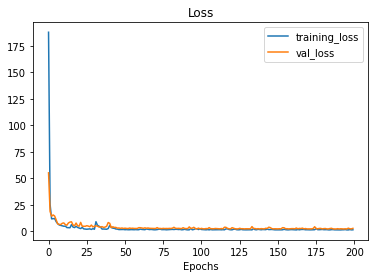

In [219]:
plot_loss_curves(history_model_6)

In [220]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 2.2731


2.273083209991455

In [221]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

10/10 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([24.577253, 25.303234, 25.17347 , 25.266718, 25.969898, 26.920515,
       26.624216, 26.677496, 27.434982, 27.853785], dtype=float32)>

In [222]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 2.2730832,
 'mse': 42.09058,
 'rmse': 6.4877253,
 'mape': 8.24006,
 'mase': 1.8071868}

In [205]:
model_2_results

{'mae': 1.2942606,
 'mse': 2.9110098,
 'rmse': 1.706168,
 'mape': 4.736191,
 'mase': 1.0192056}

In [206]:
'''
TODO:
Figure out why the multivariate time series data is performing worse, increasing
the epochs wouldn't look like it would help since the curves are sloping down.
I feel maybe I have to increase the complexity of the model?
-add more layers *
-inc # of hidden units *
-change activation func
-change optimization func
-change lr *
'''

"\nTODO:\nFigure out why the multivariate time series data is performing worse, increasing\nthe epochs wouldn't look like it would help since the curves are sloping down.\nI feel maybe I have to increase the complexity of the model?\n-add more layers\n-inc # of hidden units\n-change activation func\n-change optimization func\n-change lr\n"